In [ ]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#Pyspark installation

# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz


# install findspark using pip
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

In [ ]:
file_path = 'data_officer.csv'
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df = df.loc[df['allegation_count'].notna(), :]

df_spark=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("data_officer.csv")


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
y = df.loc[:,'allegation_count']
g = df.drop(columns=['gender', 'race', 'rank', 'resignation_date', 'appointed_date','allegation_count', 'complaint_percentile', 'civilian_allegation_percentile', 'honorable_mention_percentile','internal_allegation_percentile','trr_percentile','id','first_name','last_name','tags','active','middle_initial','middle_initial2','suffix_name','created_at','updated_at']).astype('float')

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
g1 = imp_mean.fit_transform(g)
#g = imp_mean.transform(g)
g1 = pd.DataFrame(g1, columns=g.columns)

In [ ]:
#df = df.loc[df['allegation_count'].notna(), :]
df_spark = df_spark.where(col("allegation_count").isNotNull())
df_spark = df_spark.select("gender", "race", "rank")
df_spark = df_spark.na.fill('Unknown')

In [ ]:
label_indexer_gender = StringIndexer()\
         .setInputCol ("gender")\
         .setOutputCol ("gender_label")
label_indexer_model_gender=label_indexer_gender.fit(df_spark)
df_spark=label_indexer_model_gender.transform(df_spark)

label_indexer_race = StringIndexer()\
         .setInputCol ("race")\
         .setOutputCol ("race_label")
label_indexer_model_race=label_indexer_race.fit(df_spark)
df_spark=label_indexer_model_race.transform(df_spark)

label_indexer_rank = StringIndexer()\
         .setInputCol ("rank")\
         .setOutputCol ("rank_label")
label_indexer_model_rank=label_indexer_rank.fit(df_spark)
df_spark=label_indexer_model_rank.transform(df_spark)


In [ ]:
df_spark.show(13)

+------+--------+--------------------+------------+----------+----------+
|gender|    race|                rank|gender_label|race_label|rank_label|
+------+--------+--------------------+------------+----------+----------+
|     M|   White|Lieutenant of Police|         0.0|       0.0|       4.0|
|     F|   White|      Police Officer|         1.0|       0.0|       0.0|
|     M|   Black|      Police Officer|         0.0|       1.0|       0.0|
|     M|   Black|      Police Officer|         0.0|       1.0|       0.0|
|     F|Hispanic|      Police Officer|         1.0|       2.0|       0.0|
|     M|   Black|      Police Officer|         0.0|       1.0|       0.0|
|     M|   White|Police Officer As...|         0.0|       0.0|      27.0|
|     M|   White|Police Officer as...|         0.0|       0.0|       2.0|
|     M|   Black|      Police Officer|         0.0|       1.0|       0.0|
|     M|   White|Police Officer as...|         0.0|       0.0|       2.0|
|     M|   White|      Police Officer|

In [ ]:
g2 = df_spark.select("gender_label", 'race_label', 'rank_label')
g2 = g2.toPandas()

In [ ]:
x = g1.join(g2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# Special note: for a 60/20/20 split (if you want a validation step), just do the above step again on the train set with a 2/3, 1/3 split
X_train.shape

(27071, 15)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predictions1 = model.predict(X_train)

params = np.append(model.intercept_,model.coef_)
newX = np.append(np.ones((len(X_train),1)), X_train, axis=1)
MSE = (sum((y_train-predictions1)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

from scipy import stats
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

regression_results = pd.DataFrame()
regression_results["Coefficients"],regression_results["Standard Errors"],regression_results["t values"],regression_results["p values"] = [params,sd_b,ts_b,p_values]
print(regression_results)

    Coefficients  Standard Errors  t values  p values
0       -38.5361            2.431   -15.850     0.000
1         0.0187            0.001    15.151     0.000
2         1.1399            0.049    23.241     0.000
3         0.0663            0.007     9.116     0.000
4        -0.0000            0.000    -1.806     0.071
5         0.0000            0.000    16.327     0.000
6         0.0381            0.054     0.710     0.478
7         0.0552            0.001    49.468     0.000
8         0.0016            0.000     5.727     0.000
9         0.1221            0.053     2.311     0.021
10        0.2612            0.005    51.402     0.000
11        1.4401            0.003   414.221     0.000
12        0.0285            0.054     0.530     0.596
13        0.1621            0.050     3.263     0.001
14       -0.0187            0.022    -0.835     0.404
15       -0.0238            0.005    -4.763     0.000


In [ ]:
g = (p_values[1:] < 0.0001)
X_train_new = X_train.iloc[:,g]
X_train_new.shape

(27071, 9)

In [ ]:
model2 = LinearRegression()
model2.fit(X_train_new, y_train)

predictions2 = model2.predict(X_train_new)

params = np.append(model2.intercept_,model2.coef_)
newX = np.append(np.ones((len(X_train_new),1)), X_train_new, axis=1)
MSE = (sum((y_train-predictions2)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

regression_results = pd.DataFrame()
regression_results["Coefficients"],regression_results["Standard Errors"],regression_results["t values"],regression_results["p values"] = [params,sd_b,ts_b,p_values]
print(regression_results)

   Coefficients  Standard Errors  t values  p values
0      -39.8681            2.289   -17.420       0.0
1        0.0193            0.001    16.720       0.0
2        1.1744            0.014    82.965       0.0
3        0.0672            0.007     9.246       0.0
4        0.0000            0.000    17.438       0.0
5        0.0552            0.001    50.076       0.0
6        0.0015            0.000     5.678       0.0
7        0.2608            0.005    51.475       0.0
8        1.4395            0.003   416.882       0.0
9       -0.0240            0.005    -4.810       0.0


In [ ]:
y_pred1 = model.predict(X_test)
y_pred2 = model2.predict(X_test.iloc[:,g])

[Text(0, 0.5, 'actual'),
 Text(0.5, 0, 'predicted'),
 Text(0.5, 1.0, 'selected test dataset')]

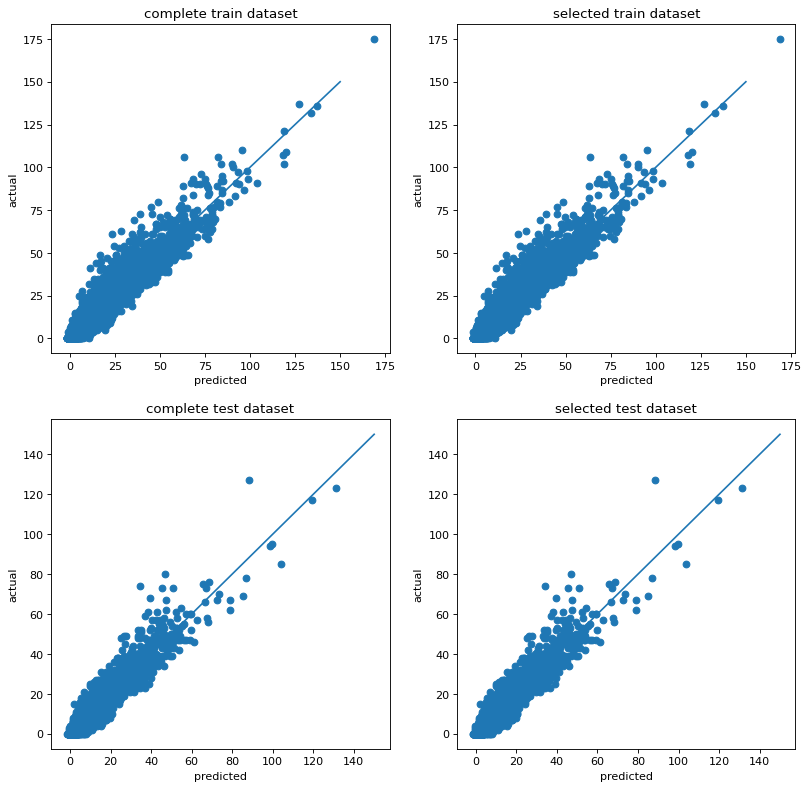

In [ ]:
# show a visualization for a scatter plot
fig = plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)
ax1.scatter(predictions1, y_train)
ax2 = fig.add_subplot(222)
ax2.scatter(predictions2, y_train)
ax3 = fig.add_subplot(223)
ax3.scatter(y_pred1, y_test)
ax4 = fig.add_subplot(224)
ax4.scatter(y_pred2, y_test)
ax1.plot([0,150],[0,150])
ax2.plot([0,150],[0,150])
ax3.plot([0,150],[0,150])
ax4.plot([0,150],[0,150])
ax1.set(title = 'complete train dataset', ylabel='actual', xlabel='predicted')
ax2.set(title = 'selected train dataset', ylabel='actual', xlabel='predicted')
ax3.set(title = 'complete test dataset', ylabel='actual', xlabel='predicted')
ax4.set(title = 'selected test dataset', ylabel='actual', xlabel='predicted')

In [ ]:
# compute accuracy score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('Original Training Data')
print('R^2 Score:', r2_score(predictions1, y_train))
print('MSE:', mean_squared_error(predictions1, y_train))
print('RMSE:', np.sqrt(mean_squared_error(predictions1, y_train)))
print('\n')

print('Original Test Data')
print('R^2 Score:', r2_score(y_test, y_pred1))
print('MSE:', mean_squared_error(y_test, y_pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred1)))
print('\n')

print('Selected Training Data')
print('R^2 Score:', r2_score(predictions2, y_train))
print('MSE:', mean_squared_error(predictions2, y_train))
print('RMSE:', np.sqrt(mean_squared_error(predictions2, y_train)))
print('\n')

print('Selected Test Data')
print('R^2 Score:', r2_score(y_test, y_pred2))
print('MSE:', mean_squared_error(y_test, y_pred2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred2)))

Original Training Data
R^2 Score: 0.9215441132484248
MSE: 8.745732822602703
RMSE: 2.957318518963201


Original Test Data
R^2 Score: 0.9218522701452442
MSE: 9.302535834455865
RMSE: 3.0500058744953042


Selected Training Data
R^2 Score: 0.9214763683106468
MSE: 8.75273475402888
RMSE: 2.9585021132371834


Selected Test Data
R^2 Score: 0.921778515498218
MSE: 9.3113154272629
RMSE: 3.0514448098012354


In [ ]:
X_train_new.columns

Index(['birth_year', 'sustained_count', 'civilian_compliment_count',
       'current_salary', 'honorable_mention_count', 'last_unit_id',
       'trr_count', 'unsustained_count', 'rank_label'],
      dtype='object')